
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [15]:
import autograd.numpy as np 
from autograd import jacobian, hessian
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb, _get_Cl_noise
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools as nd
import math as m
from fgbuster.algebra import  W_dBdB, W_dB, W, _mmm, _utmv, _mmv


In [16]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

In [17]:
nside = 64
freq_maps_N = get_observation(instrument, 'd0s0', noise=True, nside=nside)[:,1:,:]
freq_maps = get_observation(instrument, 'd0s0', noise=False, nside=nside)[:,1:,:]
n_freqs=22

In [18]:
components= [CMB(), Dust(50.), Synchrotron(50.)]

In [19]:
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
N = np.eye(len(instrument.frequency)) 
invN = np.diag((hp.nside2resol(nside, arcmin=True) / instrument.depth_p)**2)
print(invN.shape)



(22, 22)


In [20]:
dati = np.einsum('ijp,klp-> ijkl',freq_maps,freq_maps)
print(dati.shape)


(22, 2, 22, 2)


In [21]:
x1 = np.array([1.4, 19, -2.7, 0.8, 1.3, 1.2, 0.7, 0.8, 1.2, 0.9, 1.4, 1.1, 0.9, 1.3, 1.6, 0.6, 0.8, 0.9, 1.2, 1.4, 0.6, 1.8, 1.9, 0.6 ])

In [22]:

def aver_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = y
    r= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtN = A_maxL.T.dot(invN)
    NA= invN.dot(A_maxL)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    P = NA.dot(AtNA).dot(AtN)
    logL = logL -np.trace(np.einsum('fg, gikj->fk', P, dati)+np.einsum('fg, ij->gi', P, N))

    if logL != logL:
        return 0.0
    return logL

res= minimize (aver_likelihood, x1, method='Nelder-Mead')
print(res.x)

[ 1.30581386 20.02221627 -4.57990749  0.84613695  1.37779392  1.21550341
  0.90346351  1.06237362  1.08393643  0.3410566   0.81512394  1.02304302
  0.79223944  0.91300464  0.94270024  0.89065549  0.89805842  0.93750813
  1.02347917  1.02583422  1.07210653  1.12526995  1.17811066  1.22937942]


In [23]:
def A_ev_new(y):
    Bd, T, Bs, a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = y
    r= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs])))
    return A_maxL

In [24]:

A_maxL=A_ev_new(res.x)
print(A_maxL)
print(A_maxL.shape)
AtN=A_maxL.T.dot(invN)
AtNA=np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
res_ps=np.einsum ('cg,gs,sij->cij', AtNA,AtN, freq_maps)


res_ps = res_ps[0]
zeros=np.zeros((1, 49152))
unione = np.vstack((zeros, res_ps))


[[8.46136948e-01 6.25458652e-01 2.29765837e+00]
 [1.37779392e+00 1.37779392e+00 1.37779392e+00]
 [1.21550341e+00 1.56670221e+00 5.42334166e-01]
 [9.03463513e-01 1.39349531e+00 2.33196662e-01]
 [1.06237362e+00 1.63859706e+00 2.74213601e-01]
 [1.08393643e+00 2.04926191e+00 1.54833940e-01]
 [3.41056605e-01 6.44792712e-01 4.87179288e-02]
 [8.15123939e-01 1.89070207e+00 6.66167277e-02]
 [1.02304302e+00 2.37297601e+00 8.36090991e-02]
 [7.92239435e-01 2.22186834e+00 3.99708684e-02]
 [9.13004637e-01 3.47281427e+00 2.29815824e-02]
 [9.42700239e-01 4.91534495e+00 1.28329575e-02]
 [8.90655487e-01 2.49788024e+00 4.49362550e-02]
 [8.98058421e-01 3.41596304e+00 2.26053656e-02]
 [9.37508130e-01 4.88827271e+00 1.27622774e-02]
 [1.00000000e+00 7.57599640e+00 7.50144026e-03]
 [1.02347917e+00 1.16436099e+01 4.63878062e-03]
 [1.02583422e+00 1.16704022e+01 4.64945460e-03]
 [1.07210653e+00 2.12720080e+01 2.97704607e-03]
 [1.12526995e+00 4.18787039e+01 2.21789564e-03]
 [1.17811066e+00 9.83245390e+01 1.889148

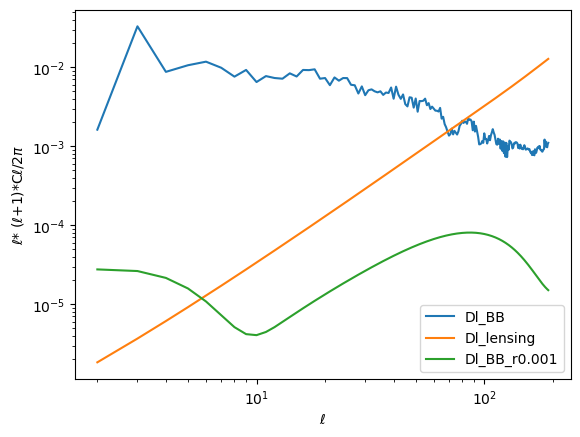

In [25]:
    
Cl =hp.anafast(unione)[2,2:] 
  
ell = np.arange(2,192)
Dl_mean = (ell*(ell+1)*Cl)/(2*m.pi)



Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][2:192]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2][2:192]
Dl_BB = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)

Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][2:192]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)


Data = Cl + Cl_lens
fsky = 1
F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2)
sigma_r_fisher = np.sqrt(1.0 / F)



plt.loglog(ell, Dl_mean, label = "Dl_BB")
plt.loglog(ell, Dl_lens, label = "Dl_lensing")
plt.loglog(ell, Dl_BB, label = "Dl_BB_r0.001")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()



In [26]:

H = nd.Hessian(aver_likelihood)
h = H(res.x)
print(h)

res.Sigma = np.linalg.inv(h)


[[ 8.12714030e+08  2.26793158e+07  3.77863199e+06 -8.71867741e+06
  -4.39033748e+05  8.29128735e+06  7.65187511e+06  4.13496216e+06
   2.20002273e+07 -2.66638718e+06  2.28310919e+07  6.50350165e+06
   3.12830376e+07  6.82811575e+07  4.54668325e+07  5.97253208e+07
   1.20220619e+08  5.77245542e+07 -3.57312739e+08 -1.61366239e+08
  -5.64973316e+08 -9.81251116e+08 -5.48930889e+08  2.10349544e+09]
 [ 2.26793158e+07  6.39557346e+05  9.45125405e+04 -2.06885238e+05
  -1.76422100e+04  1.86497516e+05  1.78035620e+05  9.62072726e+04
   5.25781803e+05 -6.37204593e+04  5.59944174e+05  1.59501397e+05
   7.87662316e+05  1.81767619e+06  1.39410559e+06  1.50379814e+06
   3.20032877e+06  1.76995234e+06 -8.85305200e+06 -3.99813258e+06
  -1.53238818e+07 -2.88706083e+07 -2.00320383e+07  6.24312966e+07]
 [ 3.77863199e+06  9.45125405e+04  2.60829610e+05 -1.60111055e+06
   6.27081286e+05  8.21477623e+05  3.20200823e+05  1.88343156e+05
   5.53446041e+05 -1.33134818e+05  3.16421716e+05  9.53623219e+04
   2.578

In [27]:
# def A_dB_ev_new(y):
#     A_dB_ev_new=np.zeros((24,22,3))
#     for i in range (22):
#         for j in range(3):
#             A_dB_ev_new[:,i,j]=nd.Derivative(A_ev_new, n=1, args=(i,j))
#     return A_dB_ev_new

In [28]:
lmax=192
lmin=2

i_cmb = A.components.index('CMB')
A_dB_maxL= A.diff_evaluator(instrument.frequency)(res.x)
A_dBdB_maxL= A.diff_diff_evaluator(instrument.frequency)(res.x)
# A_dB_maxL=np.zeros(24)
# A_dBdB_maxL=np.zeros(24)


Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=freq_maps.dtype)
Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[ i_cmb,  i_cmb, lmin:]




W_maxL = W(A_maxL, invN=invN)[ i_cmb, :]
W_dB_maxL = W_dB(A_maxL, A_dB_maxL, A.comp_of_dB, invN=invN)[:,  i_cmb]
W_dBdB_maxL = W_dBdB(A_maxL, A_dB_maxL, A_dBdB_maxL, A.comp_of_dB, invN=invN)[:, :,  i_cmb]
print(A.comp_of_dB)
print(A_maxL.shape)
print(invN.shape)




# print(res.Sigma.shape)
# print(W_dBdB_maxL.shape)
V_maxL = np.einsum('ij,ij...->...', res.Sigma, W_dBdB_maxL)





# # Check dimentions
# assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]
#                        == W_dBdB_maxL.shape[2:] == V_maxL.shape)
# assert (len(A.params) == W_dB_maxL.shape[0] 
#                             == W_dBdB_maxL.shape[0] == W_dBdB_maxL.shape[1])

# elementary quantities defined in Stompor, Errard, Poletti (2016)
Cl_xF = {}
Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)

# bias and statistical foregrounds residuals
res.noise = Cl_noise
res.bias = Cl_xF['yy'] + 2 * Cl_xF['yz']  # S16, Eq 23
res.stat = np.einsum('ij, lij -> l', res.Sigma, Cl_xF['YY'])  # E11, Eq. 12
res.var = res.stat**2 + 2 * np.einsum('li, ij, lj -> l', # S16, Eq. 28
                                          Cl_xF['Yy'], res.Sigma, Cl_xF['Yy'])

[1, 1, 2]
(22, 3)
(22, 22)


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (24,24)->(24,24) (3,3,22)->(22,3,3) 

In [ ]:
# Cl_all_g = []
# seeds = 10
# for i in range (seeds):
#     np.random.seed(i)
    

#     def spectral_likelihood(y):
#         Bd, T, Bs, a, c = y
#         b = 1
#         G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])
#         invNd = np.einsum('ij,jsp->isp', invN, freq_maps_N)
#         A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
#         logL = 0
#         AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
#         AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
#         logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
#         if logL != logL:
#             return 0.0
#         return -logL

#     min_= minimize (spectral_likelihood, x1, method='Nelder-Mead')
  
 
#     a = min_.x[3]
#     b= 1
#     c = min_.x[4]
#     G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])  
#     invNd = np.einsum('ij,jsp->isp', invN, freq_maps_N)
#     A_maxL =G.dot(A_ev(min_.x)) 

#     AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
#     AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
#     print(AtNA.shape)
#     print(AtNd.shape)


#     s = np.einsum('cg,gsp->csp', AtNA,AtNd)
#     s = s[0]
#     zeros=np.zeros((1, 49152))
#     unione = np.vstack((zeros, s))
    
    
#     Cl =hp.anafast(unione)[2,2:]
#     Cl_all_g.append(Cl)
 

# Cl_all_g=np.array(Cl_all_g)
# Cl_mean_g=np.mean(Cl_all_g, axis=0) 
# Cl_std_g = np.std(Cl_all_g, axis=0)



# ell = np.arange(2,192)
# Dl_mean_g = (ell*(ell+1)*Cl_mean_g)/(2*m.pi)
# Dl_std_g = (ell*(ell+1)*Cl_std_g)/(2*m.pi)




# Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][2:192]
# Cl_BB_r001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2][2:192]
# Dl_BB = (ell*(ell+1)*Cl_BB_r001)/(2*m.pi)

# Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][2:192]
# Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

# Data_g = Cl_mean_g + Cl_lens
# fsky = 1
# F_g = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data_g ** 2)
# sigma_r_fisher_g = np.sqrt(1.0 / F_g)
# print(F_g)
# print(sigma_r_fisher_g)





# plt.loglog(ell, Dl_mean_g, label = "Dl_BB_g")
# plt.loglog(ell, Dl_lens, label = "Dl_lensing_g")
# plt.loglog(ell, Dl_BB, label = "Dl_BB_r0.001_g")
# plt.fill_between(ell,Dl_mean_g+Dl_std_g, Dl_mean_g-Dl_std_g, alpha=0.2, label="Dl_BB_std_g")



# plt.xlabel(r'$\ell$')
# plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
# plt.legend()
